In [14]:
# If external python files are updated
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score

import functions

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device.type}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device used: cpu


# Data preprocessing


### Hyperparameters for data importation

In [15]:
train_size = 0.75                    # In percent
test_size = 1 - train_size           # In percent, calculated dynamically from train_size
batch_size = 16                      # Size of batches

## Import the dataset
Dataset should be imported as a pytorch dataloader for batch optimization

In [16]:
# Create an empty array to store the image arrays and class
X = []
Y = []

# Define the folder paths containing the images
folder_paths = ['Dataset/Non_Demented/', 'Dataset/Very_Mild_Demented/', 'Dataset/Mild_Demented/', 'Dataset/Moderate_Demented/']
classes = [r'Non demented', r'Very mildly demented', r'mild demented', r'moderate demented']

# Loop over the images to save them in the list
for path in folder_paths:
    c = folder_paths.index(path)
    items = os.listdir(path)
    for picture in items:
        file_path = os.path.join(path, picture)
        # Open the image and convert it to a NumPy array
        img = Image.open(file_path)
        array_representation = np.asarray(img)

        # Append the NumPy array to the list
        X.append(array_representation)
        Y.append(c)

# Convert the list of image arrays to a NumPy arrayF
X = np.array(X)

from sklearn.preprocessing import Normalizer
# Transpose to make each image a row
X = X.reshape(X.shape[0], -1)

# Normalize each row (i.e., each flattened image)
X = Normalizer().fit_transform(X)

# Reshape back to the original shape
X = X.reshape(X.shape)
X = X.reshape(len(X), 128, 128, 1)

# Dynamically calculate the number of classes in dataset
num_classes = len(np.unique(Y))

### Split into Test/Training sets

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 1 - train_size, stratify=Y, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 1 - train_size, stratify=Y_train, random_state=42)

for i in np.unique(Y_train):
    print(f"Elements of {i} in X_train: {np.count_nonzero(Y_train == i)}")
print()
for i in np.unique(Y_test):
    print(f"Elements of {i} in X_test: {np.count_nonzero(Y_test == i)}")
print()
for i in np.unique(Y_val):
    print(f"Elements of {i} in X_val: {np.count_nonzero(Y_val == i)}")

Elements of 0 in X_train: 1800
Elements of 1 in X_train: 1260
Elements of 2 in X_train: 504
Elements of 3 in X_train: 36

Elements of 0 in X_test: 800
Elements of 1 in X_test: 560
Elements of 2 in X_test: 224
Elements of 3 in X_test: 16

Elements of 0 in X_val: 600
Elements of 1 in X_val: 420
Elements of 2 in X_val: 168
Elements of 3 in X_val: 12


In [18]:
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2

# Assuming you have a class named MyDataset for your dataset
class MyDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        label = self.Y[idx]
        
        if self.transform:
            img = self.transform(img)

        return img, label

transformation = v2.Compose([
    # v2.ToImage(),
    # v2.ToDtype(torch.float32, scale=True),
    v2.ToDtype(torch.float32),
])

# Create an instance of your dataset
dataset_train = MyDataset(X=X_train, Y=Y_train, transform=transformation)
dataset_val = MyDataset(X=X_val, Y=Y_val, transform=transformation)
dataset_test = MyDataset(X=X_test, Y=Y_test, transform=transformation)

# Define DataLoader for training, validation and test sets
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

### Show example of dataset

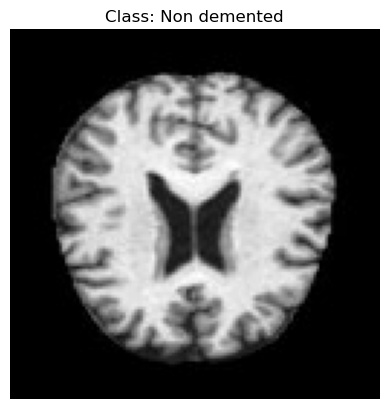

In [19]:
index_to_display = 0  # Image to show in dataset

# Get the image array and corresponding class
selected_image = X[index_to_display]
selected_class = classes[Y[index_to_display]]

# Display the image
plt.imshow(selected_image, cmap='gray')
plt.title(f'Class: {selected_class}')
plt.axis('off')  # Turn off axis labels
plt.show()

## Data augmentation

## Data normalization

# Architecture of the network

### Hyperparameters Network

In [20]:
# training
num_epochs = 5                         # Number of epochs for the training of the nn

# Learning rate und scheduler
initial_learning_rate = 0.1            # Learningrate at start
lr_steps = 5                         # Steps in lr scheduler until lr is updated
lr_gamma = 0.5                          # Faktor the lr is multiplied and updated with

In [21]:
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)                        # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:

class custom_ConvNet(nn.Module):
    def __init__(
            self,
            input_channels,
            output_size, 
            n_conv_layers1, 
            n_filters1,
            kernel_size1,
            n_dense_layers,
            n_dense_initial_nodes,
            n_conv_layers2 = 0, 
            n_filters2 = 0,
            kernel_size2 = 0,
            operation_and_factor_filter_size = ('*', 1),
            operation_and_factor_dense_network = ('*', 1),
            dropout_rate = 0,
            pooling = None,
            activation_function = F.leaky_relu,
        ):

        super(custom_ConvNet, self).__init__()

        # Dynamically get the operation and the factor with which the network will later shrink/grow layer to layer
        valid_operations = {'+': lambda x, y: x + y, '-': lambda x, y: x - y, '*': lambda x, y: x * y, '/': lambda x, y: x // y,'//': lambda x, y: x // y}
        operation_conv, factor_conv =  valid_operations.get(operation_and_factor_filter_size[0], None), operation_and_factor_filter_size[1]
        operation_dnn, factor_dnn =  valid_operations.get(operation_and_factor_dense_network[0], None), operation_and_factor_dense_network[1]

        # Save activation function for forward call
        self.activation_function = activation_function
        self.kernel_size1 = kernel_size1
        self.kernel_size2 = kernel_size2

        # Initialize modules and dropout etc
        self.dnn = nn.ModuleList()
        self.cnn1 = nn.ModuleList()
        self.cnn2 = nn.ModuleList() if n_conv_layers2 > 0 else None
        self.dropout2d = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else None
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else None
        self.pool = nn.MaxPool2d(pooling[0], pooling[1]) if pooling is not None else None

        # Initialize the dense network
        for i in np.arange(n_dense_layers): 
            if (i == 0):
                nodes = n_dense_initial_nodes
                if n_dense_layers > 1: 
                    # The input size of the first linear layer will be calculated dynamically in the first forward call
                    self.dnn.append(nn.Linear(1, n_dense_initial_nodes))
                    # self.dnn.append(nn.Linear(128**2, n_dense_initial_nodes))
                    nodes = n_dense_initial_nodes

            if ((i > 0) & (i < n_dense_layers - 1)):
                output = operation_dnn(nodes, factor_dnn)   # Calculate the shrinking (/increasing) of layer to layer nodes (if any)
                self.dnn.append(nn.Linear(nodes, output))
                nodes = output

            if (i == n_dense_layers - 1):
                print(f'Size last layer before output: {nodes}')
                self.dnn.append(nn.Linear(nodes, output_size))  # Output of the last node needs to match the number of classes

        # Build the first convolutional network part
        for i in np.arange(n_conv_layers1): 
            if i == 0:
                self.cnn1.append(nn.Conv2d(input_channels, n_filters1, kernel_size1))
                previous_filters = n_filters1

            elif ((i > 0) & (i < n_conv_layers1)):
                output_filters = operation_conv(previous_filters, factor_conv)  # Calculate the shrinking (/increasing) of layer to layer filters (if any)
                self.cnn1.append(nn.Conv2d(previous_filters, output_filters, kernel_size1))
                previous_filters = output_filters

        # Build the second convolutional network part
        for i in np.arange(n_conv_layers2): 
            if i == 0:
                self.cnn2.append(nn.Conv2d(input_channels, n_filters2, kernel_size2))
                previous_filters = n_filters2

            elif ((i > 0) & (i < n_conv_layers2)):
                output_filters = operation_conv(previous_filters, factor_conv)
                self.cnn2.append(nn.Conv2d(previous_filters, output_filters, kernel_size2))
                previous_filters = output_filters

        # Dummy value for first forward pass to get the size of x
        self.input_size = None
        self.n_dense_initial_nodes = n_dense_initial_nodes

    def forward(self, x):
        x1 = x.clone()
        for layer in self.cnn1:
            x1 = layer(x1)
            x1 = self.dropout2d(x1) if self.dropout2d is not None else x1
            x1 = self.activation_function(x1)
            x1 = self.pool(x1) if self.pool is not None else x1

        x1 = x1.view(-1, x1.shape[1] * x1.shape[2] * x1.shape[3])

        if self.cnn2 is not None:
            x2 = x.clone()
            for layer in self.cnn2:
                x2 = layer(x2)
                x2 = self.dropout2d(x2) if self.dropout2d is not None else x2
                x2 = self.activation_function(x2)
                x2 = self.pool(x2) if self.pool is not None else x2
            x2 = x2.view(-1, x2.shape[1] * x2.shape[2] * x2.shape[3])
        else:
            x2 = None

        # Put convolutional networks together
        x = torch.cat((x1, x2), dim=1) if x2 is not None else x1

        # Set input dimension of first dense layer in first forward pass
        if self.input_size is None:
            self.input_size = x.shape[1]
            self.dnn[0] = nn.Linear(self.input_size, self.n_dense_initial_nodes)
        
        for layer in self.dnn[:-1]:
            x = self.dropout(self.activation_function(layer(x))) if self.dropout is not None else self.activation_function(layer(x))
        
        # Output layer
        x = self.dnn[-1](x)
        return x

    def evaluate(self, dataloader):
        '''
        Returns the predicted labels: y_cls, y_true
        '''
        state = False if self.training is False else True
        if state: self.eval()
        y_true = []
        y_cls = []
        with torch.no_grad():  # Disable gradient computation during validation
            for i, (x_minibatch, y_true_batch) in enumerate(dataloader):
                y_pred = self(x_minibatch)
                y_cls_batch = torch.argmax(F.softmax(y_pred, dim=1), dim=1)
                y_true.append(y_true_batch.tolist())
                y_cls.append(y_cls_batch.tolist())
        y_true = np.reshape(y_true, -1)
        y_cls = np.reshape(y_cls, -1)
        if state: self.train()
        return y_cls, y_true


In [13]:
dynamic_model = functions.custom_ConvNet(
    input_channels = 1,
    output_size = 10,
    n_conv_layers1 = 0,
    n_filters1 = 4,
    kernel_size1 = 2,
    n_dense_layers = 7,
    # n_dense_initial_nodes = 2**5,
    n_dense_initial_nodes = 1024,
    n_conv_layers2 = 0,
    n_filters2 = 0, 
    kernel_size2 = 0,
    operation_and_factor_filter_size=('*', 2),
    operation_and_factor_dense_network=('/', 2),
    dropout_rate=0.0,
    # pooling = [2,2],
    activation_function = F.leaky_relu,
    )

def init_weights(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        init.zeros_(m.bias)
dynamic_model.apply(init_weights)

# from sklearn.utils.class_weight import compute_class_weight
# # Assuming 'y' is your array of class labels
# class_weights_np = compute_class_weight('balanced', classes=np.unique(Y), y=Y)
# # Assuming you have a tensor of class weights
# class_weights_tensor = torch.tensor(class_weights_np, dtype=torch.float32)


# criterion = FocalLoss()
criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(dynamic_model.parameters(), lr=initial_learning_rate)
lr_scheduler = StepLR(optimizer, step_size=lr_steps, gamma=lr_gamma)
early_stopper = functions.EarlyStopper(dynamic_model, patience=3, min_delta=0.2)

loss_training_hist, loss_val_hist, training_acc_hist, val_acc_hist = functions.train_network(dynamic_model, train_loader, criterion, optimizer, num_epochs, lr_scheduler, test_loader, device, early_stopper=early_stopper)

Size last layer before output: 32
Device used for training: cpu
Epoch [1/5], Step [112/225], Loss: 8.7842
Epoch [1/5], Step [224/225], Loss: 6.4443
Epoch [2/5], Step [112/225], Loss: 8737.4092


KeyboardInterrupt: 

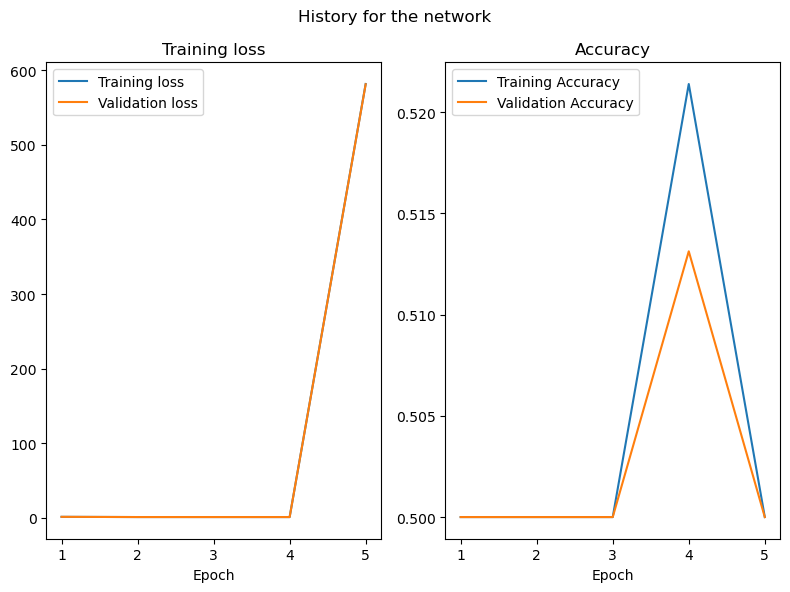

In [11]:
x_epochs = np.linspace(1, len(loss_training_hist), len(loss_training_hist))
fig, ax = plt.subplots(1, 2, figsize=(8,6))
ax[0].plot(x_epochs, loss_training_hist, label = 'Training loss')
ax[0].plot(x_epochs, loss_val_hist, label = 'Validation loss')
ax[0].set(
    xlabel='Epoch',
    title='Training loss'
)

ax[1].plot(x_epochs, training_acc_hist, label='Training Accuracy')
ax[1].plot(x_epochs, val_acc_hist, label='Validation Accuracy')
ax[1].set(
    xlabel='Epoch',
    title = 'Accuracy',
)

fig.suptitle('History for the network')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.tight_layout()
plt.show()

In [11]:
y_cls, y_true = dynamic_model.evaluate(test_loader)

from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_true, y_cls))

[[800   0   0   0]
 [560   0   0   0]
 [224   0   0   0]
 [ 16   0   0   0]]


In [12]:
from sklearn.metrics import classification_report
dynamic_model.eval()
y_true = []
y_cls = []
with torch.no_grad():  # Disable gradient computation during validation
    for i, (x_minibatch, y_true_batch) in enumerate(test_loader):
        y_pred = dynamic_model(x_minibatch)
        y_cls_batch = torch.argmax(F.softmax(y_pred, dim=1), dim=1)
        y_true.append(y_true_batch.tolist())
        y_cls.append(y_cls_batch.tolist())
y_true = np.reshape(y_true, -1)
y_cls = np.reshape(y_cls, -1)
print(classification_report(Y_test, y_cls))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       800
           1       0.00      0.00      0.00       560
           2       0.00      0.00      0.00       224
           3       0.00      0.00      0.00        16

    accuracy                           0.50      1600
   macro avg       0.12      0.25      0.17      1600
weighted avg       0.25      0.50      0.33      1600



/home/toby_linux/.local/conda/envs/ewha_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/toby_linux/.local/conda/envs/ewha_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/toby_linux/.local/conda/envs/ewha_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [13]:
# class ConvNet(nn.Module):
#     def __init__(self, in_channels, nb_filters, kernel_size_conv, fc_size, fc_out_features, pooling_size = [1, 1], activation_function = F.relu, dropout_rate_conv = 0, dropout_rate_fc = 0, padding = 0, stride = 1):
#         '''
#         in_channels         : The dimension of colors (grayscale = 1, rbg = 3)
#         nb_filters          : Number of filters applied to first layer
#         kernel_size_conv    : Size of the convolution of the first layer
#         fc_size             : Size of the first fully connected layer (output)
#         fc_out_features     : Number of classes of the dataset
#         pooling_size        : Pooling size, default = (1,1)
#         activation_function : Set the activation function for the layers, default is ReLU
#         dropout_rate_cov    : Sets the probability for dropout rates in the convolutional layers , default = 0
#         dropout_rate_fc     : Sets the probability for dropout rates in the fully connected layers , default = 0
#         padding             : Size of padding that should be applied, default = 0
#         stride              : Size of the stride applied of the convolution, default = 1
#         '''

#         # Define layers in the network
#         super(ConvNet, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels, nb_filters, kernel_size_conv)
#         self.conv2 = nn.Conv2d(nb_filters, 2 * nb_filters, kernel_size_conv)
#         self.conv3 = nn.Conv2d(2 * nb_filters,  4 *nb_filters, kernel_size_conv)
#         self.conv4 = nn.Conv2d(4 * nb_filters, 8 * nb_filters, kernel_size_conv)
#         self.conv5 = nn.Conv2d(8 * nb_filters, 16 * nb_filters, kernel_size_conv)

#         self.dropout2d = nn.Dropout2d(p=dropout_rate_conv)
#         self.pool = nn.MaxPool2d(pooling_size[0], pooling_size[1])
    
#         # Initialize these sizes for the fully connected layer and calculate this dynamically later in the first forward pass
#         self.input_size = None                  # Will later be the size of the image input
#         self.fc_size_input = None               # Will later be the size of the output of the last cnn layer (after pooling)

#         # Dummy values for Linear layers; will be updated in the first forward pass
#         self.fc1 = nn.Linear(1, 1)
#         self.fc2 = nn.Linear(1, 1)
#         self.fc3 = nn.Linear(1, 1)

#         # Dropout for fully connected layers
#         self.dropout_fc1 = nn.Dropout(p=dropout_rate_fc)
#         self.dropout_fc2 = nn.Dropout(p=dropout_rate_fc)

#         # Set some variables for the forward pass
#         self.activation_function = activation_function
#         self.fc_size = fc_size
#         self.fc_out_features = fc_out_features
#         self.pooling_size = pooling_size
#         self.padding = padding
#         self.stride = stride

#     def forward(self, x):
#         # Set the input size dynamically during the first forward pass
#         if self.input_size is None:
#             self.input_size = x.size(2)
#             self.fc_size_input = self.calculate_fc_size(self.conv1.out_channels, self.conv1.kernel_size[0])
#             print(self.fc_size_input)
#             self.fc1 = nn.Linear(self.fc_size_input, self.fc_size)
#             self.fc2 = nn.Linear(self.fc_size, int(self.fc_size / 2))
#             self.fc3 = nn.Linear(int(self.fc_size / 2), self.fc_out_features)

#         x = self.pool(self.activation_function(self.dropout2d(self.conv1(x))))
#         x = self.pool(self.activation_function(self.dropout2d(self.conv2(x))))
#         x = self.pool(self.activation_function(self.dropout2d(self.conv3(x))))
#         # x = self.pool(self.activation_function(self.dropout4(self.conv4(x))))
#         # x = self.pool(self.activation_function(self.dropout5(self.conv5(x))))
        
#         x = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
#         # x = x.view(-1, self.fc_size_input)
#         x = self.activation_function(self.dropout_fc1(self.fc1(x)))
#         x = self.activation_function(self.dropout_fc2(self.fc2(x)))
#         x = self.fc3(x)
#         return x

#     def calculate_fc_size(self, nb_filters, kernel_size_conv):
#         # Calculate the dynamic input size for fully connected layer
#         conv_output_size1 = self.calculate_conv_output_size(self.input_size, kernel_size_conv)
#         pooled_output_1 = self.calculate_conv_output_size(conv_output_size1, self.pooling_size[0], stride=self.pooling_size[1])
#         conv_output_size2 = self.calculate_conv_output_size(pooled_output_1, kernel_size_conv)
#         pooled_output_2 = self.calculate_conv_output_size(conv_output_size2, self.pooling_size[0], stride=self.pooling_size[1])
#         conv_output_size3 = self.calculate_conv_output_size(pooled_output_2, kernel_size_conv)
#         pooled_output_3 = self.calculate_conv_output_size(conv_output_size3, self.pooling_size[0], stride=self.pooling_size[1])
#         # conv_output_size4 = self.calculate_conv_output_size(pooled_output_3, kernel_size_conv)
#         # pooled_output_4 = self.calculate_conv_output_size(conv_output_size4, self.pooling_size[0], stride=self.pooling_size[1])
#         # conv_output_size5 = self.calculate_conv_output_size(pooled_output_4, kernel_size_conv)
#         # pooled_output_5 = self.calculate_conv_output_size(conv_output_size5, self.pooling_size[0], stride=self.pooling_size[1])
#         # fc_size = 16 * nb_filters * pooled_output_5**2
#         fc_size = 4 * nb_filters * pooled_output_3**2
#         return fc_size

#     def calculate_conv_output_size(self, input_size, kernel_size, stride = 1):
#         # Calculate the output size of the convolutional layer
#         return int(np.floor((input_size - kernel_size + 2 * self.padding) / stride) + 1)


# model = ConvNet(in_channels=1, nb_filters=6, kernel_size_conv=8, fc_size = 512, fc_out_features=num_classes, pooling_size=[2,2], dropout_rate_conv=0.1, dropout_rate_fc=0.1)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=initial_learning_rate)
# lr_scheduler = StepLR(optimizer, step_size=lr_steps, gamma=lr_gamma)

# loss_training_hist, loss_val_hist, training_acc_hist, val_acc_hist = functions.train_network(model, train_loader, criterion, optimizer, 1, dataloader_val = validation_loader, learning_rate_scheduler=lr_scheduler)

Device used for training: cpu
1944
Test


RuntimeError: Given groups=1, weight of size [6, 1, 8, 8], expected input[16, 128, 128, 1] to have 1 channels, but got 128 channels instead